In [193]:
import pandas as pd
data = pd.read_csv("multilingual_mobile_app_reviews_2025.csv")
data.head()


,review_id,user_id,app_name,app_category,review_text,review_language,rating,review_date,verified_purchase,device_type,num_helpful_votes,user_age,user_country,user_gender,app_version
0,1,1967825,MX Player,Travel & Local,Qui doloribus consequuntur. Perspiciatis tempo...,no,1.3,2024-10-09 19:26:40,True,Android Tablet,65,14.0,China,Female,1.4
1,2,9242600,Tinder,Navigation,"Great app but too many ads, consider premium v...",ru,1.6,2024-06-21 17:29:40,True,iPad,209,18.0,Germany,Male,8.9
2,3,7636477,Netflix,Dating,The interface could be better but overall good...,es,3.6,2024-10-31 13:47:12,True,iPad,163,67.0,Nigeria,Male,2.8.37.5926
3,4,209031,Venmo,Productivity,"Latest update broke some features, please fix ...",vi,3.8,2025-03-12 06:16:22,True,iOS,664,66.0,India,Female,10.2
4,5,7190293,Google Drive,Education,"Perfect for daily use, highly recommend to eve...",tl,3.2,2024-04-21 03:48:27,True,iPad,1197,40.0,South Korea,Prefer not to say,4.7


In [98]:
import numpy as np
np.random.seed(0)
i_weight = np.random.rand(1, 2)
h_weight =  np.random.rand(2, 2)
o_weight = np.random.rand(2, 1)
temps = data["rating"].tail(3).to_numpy()
temps



array([3.4, 2.7, 2.1])

In [99]:
x0 = temps[0].reshape(1, 1)
x1 = temps[1].reshape(1, 1)
x2 = temps[2].reshape(1, 1)
x0

array([[3.4]])

In [100]:
xi_0 = x0 @ i_weight
xi_0

array([[1.86596591, 2.43164385]])

In [101]:
xh_0 = np.maximum(0, xi_0)
xh_0

array([[1.86596591, 2.43164385]])

In [102]:
xo_0 = xh_0 @ o_weight
xo_0

array([[2.98499715]])

In [103]:
xi_1 = x1 @ i_weight
xh = xh_0 @ h_weight
xh_1 = np.maximum(0, xh + xi_1)
xo_1 = xh_1 @ o_weight
xo_1

array([[5.62070174]])

In [104]:
xi_2 = x2 @ i_weight
xh = xh_1 @ h_weight
xh_2 = np.maximum(0, xh + xi_2)
xo_2 = xh_2 @ o_weight
xo_2

array([[8.01017162]])

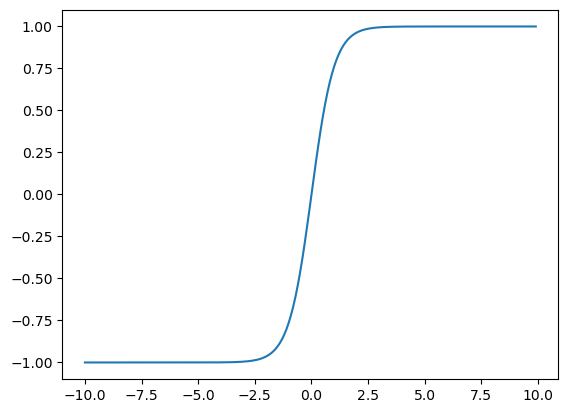

In [105]:
import matplotlib.pyplot as plt
temps = np.arange(-10, 10, 0.10)
plt.plot(temps, np.tanh(temps))

In [106]:
from sympy import diff, symbols, exp
x = symbols("x")
sympy_tanh = (exp(x) - exp(-x))/ (exp(x) + exp(-x))
tanh_deriv = diff(sympy_tanh, x)

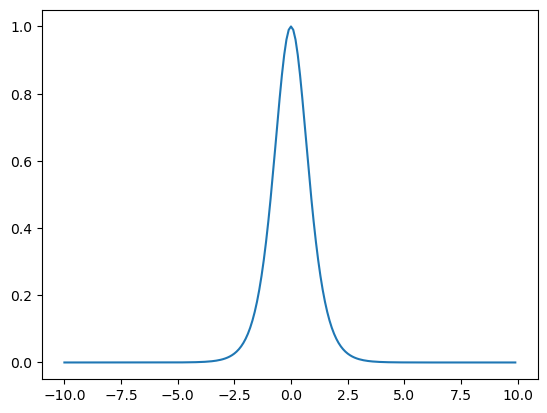

In [107]:
plt.plot(temps, 1 - np.tanh(temps) ** 2)

In [108]:
np.random.seed(0)

i_weight = np.random.rand(1, 5) / 5 - 0.10
h_weight = np.random.rand(5, 5) / 5 - 0.10
h_bias = np.random.rand(1, 5) / 5 - 0.10

o_weight = np.random.rand(5, 1) * 50
o_bias = np.random.rand(1, 1)


In [109]:
outputs = np.zeros(3)
hiddens = np.zeros((3, 5))
prev_hidden = None
sequence = data["rating"].tail(3).to_numpy()

for i in range(3):
    x = sequence[i].reshape(1, 1)
    xi = x @ i_weight 
    if prev_hidden is None:
        xh = xi
    else:
        xh = xi + prev_hidden @ h_weight + h_bias 
    xh = np.tanh(xh)
    prev_hidden = xh
    hiddens[i, :] = xh
    xo = (xh @ o_weight) + o_bias  
    outputs[i] = xo.item()


In [110]:
outputs

array([7.65440354, 4.40867935, 2.88757189])

In [111]:
hiddens

array([[ 0.033181  ,  0.14529323,  0.06976558,  0.03051109, -0.05186815],
       [-0.0155747 ,  0.16867764,  0.05104824,  0.05866684, -0.14593883],
       [-0.01988098,  0.15417756,  0.02542544,  0.05090088, -0.13970597]])

In [151]:
def mse(actual, predicted):
    return np.mean((actual - predicted) ** 2)
def mse_grad(actual, predicted):
    return (predicted - actual)


In [113]:
actuals = [1.3, 1.6, 3.6]
loss_grad = mse_grad(actuals, outputs)
loss_grad

array([ 6.35440354,  2.80867935, -0.71242811])

In [114]:
next_hidden = None
o_weight_grad, o_bias_grad, h_weight_grad, h_bias_grad, i_weight_grad = [0] * 5
for i in range(2, -1, -1):
    l_grad = loss_grad[i].reshape(1, 1)
    o_weight_grad += hiddens[i][:, np.newaxis] @ l_grad
    o_bias_grad += np.mean(l_grad)
    o_grad = l_grad @ o_weight.T
    if next_hidden is None:
        h_grad = o_grad
    else:
        h_grad = o_grad + next_hidden @ h_weight.T
    tanh_deriv = 1 - hiddens[i, :][np.newaxis, :]
    h_grad = np.multiply(h_grad, tanh_deriv)
    next_hidden = h_grad
    if i > 0:
        h_weight_grad += hiddens[i - 1, :][:, np.newaxis] @ h_grad
        h_bias_grad += np.mean(h_grad)
    i_weight_grad += sequence[i].reshape(1, 1).T @ h_grad


In [115]:
i_weight_grad

array([[ 878.51073914,  736.41082943,  813.69533406, 1284.52198543,
        1021.63382112]])

In [116]:
lr = 1e-6
i_weight -= i_weight_grad * lr
h_weight -= h_weight_grad * lr
h_bias -= h_bias_grad * lr
o_weight -= o_weight_grad * lr
o_bias -= o_bias_grad * lr

In [117]:
i_weight

array([[ 0.00888419,  0.04230146,  0.01973898,  0.00769211, -0.01629067]])

In [178]:
from sklearn.preprocessing import StandardScaler
import math
import numpy as np

# Sample data setup (replace with your actual data loading)
# Assuming you have 'data' DataFrame with the required columns
PREDICTORS = ["user_age", "num_helpful_votes"]
TARGET = "rating"

# Data preprocessing
scaler = StandardScaler()
# Ensure no NaN values in the data before scaling
if 'data' in locals():
    data = data.dropna()  # Remove any NaN values
    data[PREDICTORS] = scaler.fit_transform(data[PREDICTORS])

    # Split data
    np.random.seed(0)
    split_data = np.split(data, [int(0.70 * len(data)), int(0.85 * len(data))])
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = [
        [d[PREDICTORS].to_numpy(), d[[TARGET]].to_numpy()] for d in split_data
    ]
    
    print("Data shapes:")
    print(f"Train X: {train_x.shape}, Train Y: {train_y.shape}")
    print(f"Valid X: {valid_x.shape}, Valid Y: {valid_y.shape}")
    print(f"Target range: {train_y.min():.3f} to {train_y.max():.3f}")

Data shapes:
Train X: (1260, 2), Train Y: (1260, 1)
Valid X: (270, 2), Valid Y: (270, 1)
Target range: 1.000 to 5.000


c:\Users\Kille\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [165]:
import numpy as np
import math

def mse(actual, predicted):
    return np.mean((actual - predicted) ** 2)

def mse_grad(actual, predicted):
    # Add small epsilon to prevent division by zero
    return 2 * (predicted - actual) / actual.shape[0]

def init_params(layer_conf):
    layers = []
    for i in range(1, len(layer_conf)):
        np.random.seed(0)
        k = 1/math.sqrt(layer_conf[i]["hidden"])
        i_weight = np.random.rand(layer_conf[i-1]["units"], layer_conf[i]["hidden"]) * 2 * k - k

        h_weight = np.random.rand(layer_conf[i]["hidden"], layer_conf[i]["hidden"]) * 2 * k - k
        h_bias = np.random.rand(1, layer_conf[i]["hidden"]) * 2 * k - k

        o_weight = np.random.rand(layer_conf[i]["hidden"], layer_conf[i]["output"]) * 2 * k - k
        o_bias = np.random.rand(1, layer_conf[i]["output"]) * 2 * k - k

        layers.append(
            [i_weight, h_weight, h_bias, o_weight, o_bias]
        )
    return layers

In [166]:
layers_conf = [
    {"type": "input", "units": 2},
    {"type": "rnn", "hidden": 4, "output": 1}
]

In [ ]:
def forward(x, layers):
    hiddens = []
    outputs = []
    for i in range(len(layers)):
        i_weight, h_weight, h_bias, o_weight, o_bias = layers[i]
        hidden = np.zeros((x.shape[0], i_weight.shape[1]))
        output = np.zeros((x.shape[0], o_weight.shape[1]))
        
        for j in range(x.shape[0]):
            input_x = x[j, :][np.newaxis, :] @ i_weight
            if j == 0:
                prev_hidden = np.zeros((1, h_weight.shape[0]))
            else:
                prev_hidden = hidden[j-1, :][np.newaxis, :]
            hidden_x = input_x + prev_hidden @ h_weight + h_bias
            hidden_x = np.tanh(hidden_x)
            hidden[j, :] = hidden_x
            output_x = hidden_x @ o_weight + o_bias
            output[j, :] = output_x
        hiddens.append(hidden)
        outputs.append(output)
    return hiddens, outputs[-1]

In [195]:
def backward(layers, x, lr, grad, hiddens):
    for i in range(len(layers)):
        i_weight, h_weight, h_bias, o_weight, o_bias = layers[i]
        hidden = hiddens[i]
        next_h_grad = None
        i_weight_grad = np.zeros_like(i_weight)
        h_weight_grad = np.zeros_like(h_weight)
        h_bias_grad = np.zeros_like(h_bias)
        o_weight_grad = np.zeros_like(o_weight)
        o_bias_grad = np.zeros_like(o_bias)

        for j in range(x.shape[0] - 1, -1, -1):
            out_grad = grad[j,:][np.newaxis, :]
            o_weight_grad += hidden[j,:][:, np.newaxis] @ out_grad
            o_bias_grad += out_grad
            h_grad = out_grad @ o_weight.T
            if j < x.shape[0] - 1:
                hh_grad = next_h_grad @ h_weight.T
                h_grad += hh_grad
            tanh_deriv = 1 - hidden[j][np.newaxis,:] ** 2
            h_grad = np.multiply(h_grad, tanh_deriv)
            next_h_grad = h_grad.copy()
            if j > 0:
                h_weight_grad += hidden[j-1][:, np.newaxis] @ h_grad
                h_bias_grad += h_grad

            i_weight_grad += x[j,:][:,np.newaxis] @ h_grad
        lr = lr / x.shape[0]
        i_weight -= i_weight_grad * lr
        h_weight -= h_weight_grad * lr
        h_bias -= h_bias_grad * lr
        o_weight -= o_weight_grad * lr
        o_bias -= o_bias_grad * lr
        layers[i] = [i_weight, h_weight, h_bias, o_weight, o_bias]
    return layers

In [198]:
epochs = 250
lr = 1e-3

layer_conf = [
    {"type":"input", "units": 2},
    {"type": "rnn", "hidden": 128, "output": 1}
]
layers = init_params(layer_conf)

for epoch in range(epochs + 1):
    sequence_len = 14
    epoch_loss = 0
    for j in range(train_x.shape[0] - sequence_len):
        seq_x = train_x[j:(j+sequence_len),]
        seq_y = train_y[j:(j+sequence_len),]
        hiddens, outputs = forward(seq_x, layers)
        grad = mse_grad(seq_y, outputs)
        params = backward(layers, seq_x, lr, grad, hiddens)
        epoch_loss += mse(seq_y, outputs)

    if epoch % 50 == 0:
        sequence_len = 7
        valid_loss = 0
        for j in range(valid_x.shape[0] - sequence_len):
            seq_x = valid_x[j:(j+sequence_len),]
            seq_y = valid_y[j:(j+sequence_len),]
            _, outputs = forward(seq_x, layers)
            valid_loss += mse(seq_y, outputs)

        print(f"Epoch: {epoch} train loss {epoch_loss / len(train_x)} valid loss {valid_loss / len(valid_x)}")

Epoch: 0 train loss 6.869410127688549 valid loss 3.0034497085723006
Epoch: 50 train loss 1.3188024538730816 valid loss 1.2661270394614437
Epoch: 100 train loss 1.2996743266645345 valid loss 1.2375744899706844
Epoch: 150 train loss 1.2939009412724176 valid loss 1.2317302436859507
Epoch: 200 train loss 1.291461504734016 valid loss 1.2297346958059119
Epoch: 250 train loss 1.2901533770755167 valid loss 1.2288276808850835
